In [ ]:
histopathology (histo): 조직병리학적 검사를 통해 확인된 진단
follow-up examination (follow_up): 추적 검사를 통해 확인된 진단
expert consensus (consensus): 전문가 합의를 통해 확인된 진단
confirmation by in-vivo confocal microscopy (confocal): 인체 내 현미경을 사용하여 확인된 진단

dx는 진단(diagnosis)을 의미
"dx":

(nv)    Melanocytic nevi (흑색종)                  멜라닌세포모반은 모반세포(점세포, nevus cell, nevomelanocyte)로 이루어진 양성 종양
(mel)   Melanoma (흑색종)                          악성 흑색종은 멜라닌 생성 세포로 구성된 피부 악성 신생물(암)
(bkl)   Benign keratosis-like lesions (양성 각화 유사 병변) 
(bcc)   Basal cell carcinoma (기저세포암)           기저세포 암종은 표피 및 그 부속기 기저부의 비각질화 세포에서 유래한 악성 종양
(akiec) Actinic keratoses (광선각화증)              광선 각화증이란 지속적인 햇빛 노출에 의해 피부에 인설이 동반된 분홍색 또는 적색의 반점이나 구진이 생기는 피부 병변
(vasc)  Vascular lesions (혈관병변)                 피부나 점막에 발생하는 혈관 관련 이상
(df)    Dermatofibroma (피부섬유종)                  진피의 섬유성 종양 모양의 결절.

dx_type은 진단의 유형을 나타냅니다. 각 진단이 어떻게 확인되었는지를 나타냅니다.
"dx_type":

(histo)      histo: 조직 검사 결과를 기반으로 한 진단                                            histopathological(조직학적)
(follow_up)  follow-up examination : 진단 후 추적 관찰                                         follow-up(후행, 추적)
(consensus)  expert consensus: 전문가 그룹의 의견을 바탕으로 한 합의 진단                         consensus(합의)
(confocal)   confirmation by in-vivo confocal microscopy : 조직 검사 대신 피부 조절 현미경 사용  confocal(공초점의)

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
from glob import glob
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, concatenate, Dense, BatchNormalization, Dropout
from keras import backend as K
import itertools

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


In [3]:
base_skin_dir = os.path.join('.','archive')
#print(base_skin_dir)  --> .\archive

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, 'HAM10000_images', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
imageid_path_dict
#for dirname, _, filenames in os.walk('./archive'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

{'ISIC_0024306': '.\\archive\\HAM10000_images\\ISIC_0024306.jpg',
 'ISIC_0024307': '.\\archive\\HAM10000_images\\ISIC_0024307.jpg',
 'ISIC_0024308': '.\\archive\\HAM10000_images\\ISIC_0024308.jpg',
 'ISIC_0024309': '.\\archive\\HAM10000_images\\ISIC_0024309.jpg',
 'ISIC_0024310': '.\\archive\\HAM10000_images\\ISIC_0024310.jpg',
 'ISIC_0024311': '.\\archive\\HAM10000_images\\ISIC_0024311.jpg',
 'ISIC_0024312': '.\\archive\\HAM10000_images\\ISIC_0024312.jpg',
 'ISIC_0024313': '.\\archive\\HAM10000_images\\ISIC_0024313.jpg',
 'ISIC_0024314': '.\\archive\\HAM10000_images\\ISIC_0024314.jpg',
 'ISIC_0024315': '.\\archive\\HAM10000_images\\ISIC_0024315.jpg',
 'ISIC_0024316': '.\\archive\\HAM10000_images\\ISIC_0024316.jpg',
 'ISIC_0024317': '.\\archive\\HAM10000_images\\ISIC_0024317.jpg',
 'ISIC_0024318': '.\\archive\\HAM10000_images\\ISIC_0024318.jpg',
 'ISIC_0024319': '.\\archive\\HAM10000_images\\ISIC_0024319.jpg',
 'ISIC_0024320': '.\\archive\\HAM10000_images\\ISIC_0024320.jpg',
 'ISIC_002

In [4]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [5]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,.\archive\HAM10000_images\ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,.\archive\HAM10000_images\ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,.\archive\HAM10000_images\ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,.\archive\HAM10000_images\ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,.\archive\HAM10000_images\ISIC_0031633.jpg,Benign keratosis-like lesions,2


In [6]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [7]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

In [8]:
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [9]:
print(skin_df.dtypes)

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object


dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


<Axes: xlabel='cell_type'>

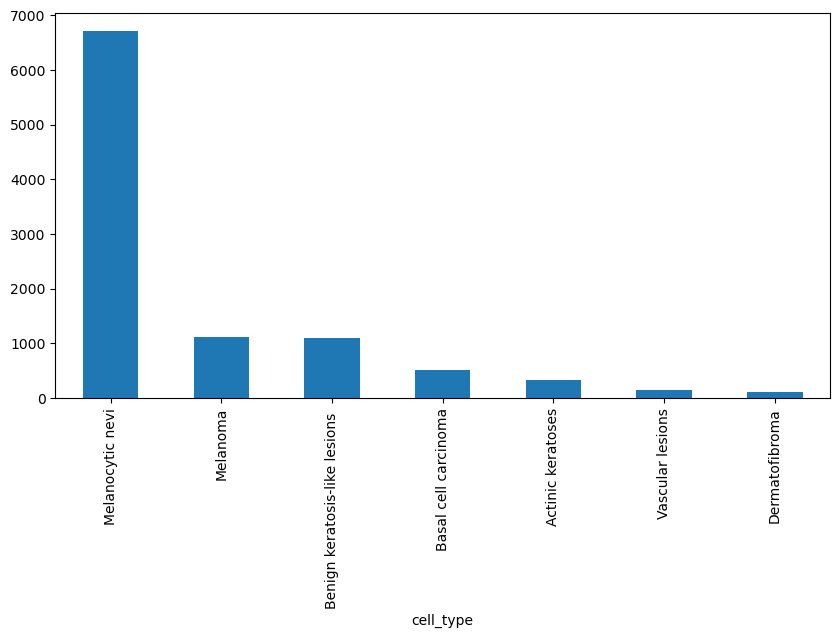

In [10]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
print(skin_df['dx'].value_counts())
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

In [11]:
from PIL import Image
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((80, 60))))

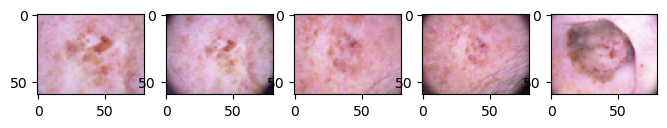

In [12]:
plt.figure(figsize=(8, 6))
for i in range(5):
  plt.subplot(1,5,i+1) # 행 하나, 열 다섯 개, 1로 시작하는 인덱스|
  plt.imshow(skin_df['image'][i])
plt.show()

In [13]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,.\archive\HAM10000_images\ISIC_0027419.jpg,Benign keratosis-like lesions,2,"[[[191, 151, 193], [191, 153, 194], [192, 152,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,.\archive\HAM10000_images\ISIC_0025030.jpg,Benign keratosis-like lesions,2,"[[[23, 13, 22], [24, 14, 26], [29, 17, 36], [4..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,.\archive\HAM10000_images\ISIC_0026769.jpg,Benign keratosis-like lesions,2,"[[[185, 128, 139], [190, 133, 148], [196, 141,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,.\archive\HAM10000_images\ISIC_0025661.jpg,Benign keratosis-like lesions,2,"[[[23, 11, 18], [31, 16, 26], [50, 28, 39], [7..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,.\archive\HAM10000_images\ISIC_0031633.jpg,Benign keratosis-like lesions,2,"[[[137, 93, 116], [153, 108, 132], [169, 124, ..."


In [14]:
nv_skin_df = skin_df[skin_df['dx'] == 'bkl'] #6705
mel_skin_df = skin_df[skin_df['dx'] == 'mel'] #1113
bkl_skin_df = skin_df[skin_df['dx'] == 'bkl'] #1099
bcc_skin_df = skin_df[skin_df['dx'] == 'bcc'] #514
akiec_skin_df = skin_df[skin_df['dx'] == 'akiec'] #327
vasc_skin_df = skin_df[skin_df['dx'] == 'vasc'] #142
df_skin_df = skin_df[skin_df['dx'] == 'df'] #115
df_skin_df['image'].shape

(115,)

In [15]:
# Data Augmentation on train set 
import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,
        brightness_range=(0.8, 1.2) # 0.8배에서 1.2배
        )  # randomly flip images

In [16]:
df_skin_df.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'path', 'cell_type', 'cell_type_idx', 'image'],
      dtype='object')

In [17]:
bcc_skin_df.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'path', 'cell_type', 'cell_type_idx', 'image'],
      dtype='object')

In [18]:
# mel
# 1113
augmented_mel = pd.DataFrame(columns=mel_skin_df.columns)  # 기존 데이터프레임과 동일한 열을 가지는 새로운 데이터프레임 생성

multi = 3

# 배열 채우기, 훈련 데이터에서 한 장씩 꺼내 multi 개씩 만듭니다.
for i in range(len(mel_skin_df)):
    # 이미지와 관련된 메타데이터 가져오기
    image_row = mel_skin_df.iloc[i]
    image = image_row['image']
    metadata = image_row.drop('image')  # 이미지 열 제외한 메타데이터 추출

    # 각 이미지와 관련된 메타데이터를 multi 만큼 복사하여 새로운 데이터프레임에 추가
    for j in range(multi):
        augmented_image = datagen.random_transform(image)  # 이미지 증강
        
        # 증강된 이미지와 원본 이미지의 메타데이터를 새로운 행으로 추가
        augmented_metadata = metadata.copy()  # 메타데이터를 복사하여 수정된 이미지와 함께 추가
        augmented_metadata['image'] = augmented_image  # 이미지 열에 증강된 이미지 추가
        augmented_mel.loc[i*multi + j] = augmented_metadata


# 결과 확인
augmented_mel.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000871,ISIC_0025964,mel,histo,40.0,female,chest,.\archive\HAM10000_images\ISIC_0025964.jpg,Melanoma,5,"[[[196.0, 163.0, 169.0], [196.0, 161.0, 174.0]..."
1,HAM_0000871,ISIC_0025964,mel,histo,40.0,female,chest,.\archive\HAM10000_images\ISIC_0025964.jpg,Melanoma,5,"[[[83.0, 72.0, 78.0], [83.0, 72.0, 78.0], [83...."
2,HAM_0000871,ISIC_0025964,mel,histo,40.0,female,chest,.\archive\HAM10000_images\ISIC_0025964.jpg,Melanoma,5,"[[[223.0, 193.0, 216.0], [224.0, 194.0, 215.0]..."
3,HAM_0000871,ISIC_0030623,mel,histo,40.0,female,chest,.\archive\HAM10000_images\ISIC_0030623.jpg,Melanoma,5,"[[[192.0, 167.0, 184.0], [193.0, 166.0, 181.0]..."
4,HAM_0000871,ISIC_0030623,mel,histo,40.0,female,chest,.\archive\HAM10000_images\ISIC_0030623.jpg,Melanoma,5,"[[[231.0, 202.0, 222.0], [231.0, 202.0, 222.0]..."


In [19]:
# augmented_bkl = pd.DataFrame(columns=bkl_skin_df.columns)  # 기존 데이터프레임과 동일한 열을 가지는 새로운 데이터프레임 생성
# 1099

augmented_bkl = pd.DataFrame(columns=bkl_skin_df.columns)  # 기존 데이터프레임과 동일한 열을 가지는 새로운 데이터프레임 생성

multi = 3

# 배열 채우기, 훈련 데이터에서 한 장씩 꺼내 multi 개씩 만듭니다.
for i in range(len(bkl_skin_df)):
    # 이미지와 관련된 메타데이터 가져오기
    image_row = bkl_skin_df.iloc[i]
    image = image_row['image']
    metadata = image_row.drop('image')  # 이미지 열 제외한 메타데이터 추출

    # 각 이미지와 관련된 메타데이터를 multi 만큼 복사하여 새로운 데이터프레임에 추가
    for j in range(multi):
        augmented_image = datagen.random_transform(image)  # 이미지 증강
        
        # 증강된 이미지와 원본 이미지의 메타데이터를 새로운 행으로 추가
        augmented_metadata = metadata.copy()  # 메타데이터를 복사하여 수정된 이미지와 함께 추가
        augmented_metadata['image'] = augmented_image  # 이미지 열에 증강된 이미지 추가
        augmented_bkl.loc[i*multi + j] = augmented_metadata


# 결과 확인
augmented_bkl.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,.\archive\HAM10000_images\ISIC_0027419.jpg,Benign keratosis-like lesions,2,"[[[169.0, 140.0, 157.0], [169.0, 140.0, 157.0]..."
1,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,.\archive\HAM10000_images\ISIC_0027419.jpg,Benign keratosis-like lesions,2,"[[[229.0, 178.0, 195.0], [231.0, 179.0, 196.0]..."
2,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,.\archive\HAM10000_images\ISIC_0027419.jpg,Benign keratosis-like lesions,2,"[[[215.0, 171.0, 197.0], [216.0, 174.0, 203.0]..."
3,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,.\archive\HAM10000_images\ISIC_0025030.jpg,Benign keratosis-like lesions,2,"[[[102.0, 75.0, 99.0], [111.0, 80.0, 106.0], [..."
4,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,.\archive\HAM10000_images\ISIC_0025030.jpg,Benign keratosis-like lesions,2,"[[[114.0, 86.0, 106.0], [111.0, 84.0, 105.0], ..."


In [20]:
# bcc
#514

augmented_bcc = pd.DataFrame(columns=bcc_skin_df.columns)  # 기존 데이터프레임과 동일한 열을 가지는 새로운 데이터프레임 생성

multi = 6

# 배열 채우기, 훈련 데이터에서 한 장씩 꺼내 multi 개씩 만듭니다.
for i in range(len(bcc_skin_df)):
    # 이미지와 관련된 메타데이터 가져오기
    image_row = bcc_skin_df.iloc[i]
    image = image_row['image']
    metadata = image_row.drop('image')  # 이미지 열 제외한 메타데이터 추출

    # 각 이미지와 관련된 메타데이터를 multi 만큼 복사하여 새로운 데이터프레임에 추가
    for j in range(multi):
        augmented_image = datagen.random_transform(image)  # 이미지 증강
        
        # 증강된 이미지와 원본 이미지의 메타데이터를 새로운 행으로 추가
        augmented_metadata = metadata.copy()  # 메타데이터를 복사하여 수정된 이미지와 함께 추가
        augmented_metadata['image'] = augmented_image  # 이미지 열에 증강된 이미지 추가
        augmented_bcc.loc[i*multi + j] = augmented_metadata


# 결과 확인
augmented_bcc.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000781,ISIC_0028155,bcc,histo,50.0,male,back,.\archive\HAM10000_images\ISIC_0028155.jpg,Basal cell carcinoma,1,"[[[167.0, 109.0, 103.0], [204.0, 141.0, 136.0]..."
1,HAM_0000781,ISIC_0028155,bcc,histo,50.0,male,back,.\archive\HAM10000_images\ISIC_0028155.jpg,Basal cell carcinoma,1,"[[[20.0, 15.0, 18.0], [17.0, 14.0, 14.0], [16...."
2,HAM_0000781,ISIC_0028155,bcc,histo,50.0,male,back,.\archive\HAM10000_images\ISIC_0028155.jpg,Basal cell carcinoma,1,"[[[255.0, 243.0, 245.0], [255.0, 242.0, 244.0]..."
3,HAM_0000781,ISIC_0028155,bcc,histo,50.0,male,back,.\archive\HAM10000_images\ISIC_0028155.jpg,Basal cell carcinoma,1,"[[[249.0, 222.0, 223.0], [253.0, 229.0, 231.0]..."
4,HAM_0000781,ISIC_0028155,bcc,histo,50.0,male,back,.\archive\HAM10000_images\ISIC_0028155.jpg,Basal cell carcinoma,1,"[[[165.0, 144.0, 148.0], [157.0, 137.0, 143.0]..."


In [21]:
# akiec
# 327

augmented_akiec = pd.DataFrame(columns=akiec_skin_df.columns)  # 기존 데이터프레임과 동일한 열을 가지는 새로운 데이터프레임 생성

multi = 8

# 배열 채우기, 훈련 데이터에서 한 장씩 꺼내 multi 개씩 만듭니다.
for i in range(len(akiec_skin_df)):
    # 이미지와 관련된 메타데이터 가져오기
    image_row = akiec_skin_df.iloc[i]
    image = image_row['image']
    metadata = image_row.drop('image')  # 이미지 열 제외한 메타데이터 추출

    # 각 이미지와 관련된 메타데이터를 multi 만큼 복사하여 새로운 데이터프레임에 추가
    for j in range(multi):
        augmented_image = datagen.random_transform(image)  # 이미지 증강
        
        # 증강된 이미지와 원본 이미지의 메타데이터를 새로운 행으로 추가
        augmented_metadata = metadata.copy()  # 메타데이터를 복사하여 수정된 이미지와 함께 추가
        augmented_metadata['image'] = augmented_image  # 이미지 열에 증강된 이미지 추가
        augmented_akiec.loc[i*multi + j] = augmented_metadata


# 결과 확인
augmented_akiec.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0002644,ISIC_0029417,akiec,histo,80.0,female,neck,.\archive\HAM10000_images\ISIC_0029417.jpg,Actinic keratoses,0,"[[[37.0, 19.0, 25.0], [37.0, 19.0, 25.0], [37...."
1,HAM_0002644,ISIC_0029417,akiec,histo,80.0,female,neck,.\archive\HAM10000_images\ISIC_0029417.jpg,Actinic keratoses,0,"[[[93.0, 57.0, 65.0], [96.0, 58.0, 67.0], [94...."
2,HAM_0002644,ISIC_0029417,akiec,histo,80.0,female,neck,.\archive\HAM10000_images\ISIC_0029417.jpg,Actinic keratoses,0,"[[[27.0, 13.0, 18.0], [27.0, 13.0, 18.0], [27...."
3,HAM_0002644,ISIC_0029417,akiec,histo,80.0,female,neck,.\archive\HAM10000_images\ISIC_0029417.jpg,Actinic keratoses,0,"[[[119.0, 93.0, 88.0], [117.0, 91.0, 86.0], [1..."
4,HAM_0002644,ISIC_0029417,akiec,histo,80.0,female,neck,.\archive\HAM10000_images\ISIC_0029417.jpg,Actinic keratoses,0,"[[[112.0, 85.0, 87.0], [126.0, 99.0, 99.0], [1..."


In [22]:
# vasc
# 142

augmented_vasc = pd.DataFrame(columns=vasc_skin_df.columns)  # 기존 데이터프레임과 동일한 열을 가지는 새로운 데이터프레임 생성

multi = 14

# 배열 채우기, 훈련 데이터에서 한 장씩 꺼내 multi 개씩 만듭니다.
for i in range(len(vasc_skin_df)):
    # 이미지와 관련된 메타데이터 가져오기
    image_row = vasc_skin_df.iloc[i]
    image = image_row['image']
    metadata = image_row.drop('image')  # 이미지 열 제외한 메타데이터 추출

    # 각 이미지와 관련된 메타데이터를 multi 만큼 복사하여 새로운 데이터프레임에 추가
    for j in range(multi):
        augmented_image = datagen.random_transform(image)  # 이미지 증강
        
        # 증강된 이미지와 원본 이미지의 메타데이터를 새로운 행으로 추가
        augmented_metadata = metadata.copy()  # 메타데이터를 복사하여 수정된 이미지와 함께 추가
        augmented_metadata['image'] = augmented_image  # 이미지 열에 증강된 이미지 추가
        augmented_vasc.loc[i*multi + j] = augmented_metadata


# 결과 확인
augmented_vasc.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0006889,ISIC_0031197,vasc,histo,20.0,male,upper extremity,.\archive\HAM10000_images\ISIC_0031197.jpg,Vascular lesions,6,"[[[232.0, 203.0, 227.0], [232.0, 205.0, 227.0]..."
1,HAM_0006889,ISIC_0031197,vasc,histo,20.0,male,upper extremity,.\archive\HAM10000_images\ISIC_0031197.jpg,Vascular lesions,6,"[[[193.0, 156.0, 183.0], [196.0, 162.0, 190.0]..."
2,HAM_0006889,ISIC_0031197,vasc,histo,20.0,male,upper extremity,.\archive\HAM10000_images\ISIC_0031197.jpg,Vascular lesions,6,"[[[212.0, 178.0, 202.0], [213.0, 180.0, 204.0]..."
3,HAM_0006889,ISIC_0031197,vasc,histo,20.0,male,upper extremity,.\archive\HAM10000_images\ISIC_0031197.jpg,Vascular lesions,6,"[[[202.0, 172.0, 194.0], [203.0, 173.0, 195.0]..."
4,HAM_0006889,ISIC_0031197,vasc,histo,20.0,male,upper extremity,.\archive\HAM10000_images\ISIC_0031197.jpg,Vascular lesions,6,"[[[213.0, 185.0, 207.0], [213.0, 185.0, 207.0]..."


In [23]:
# df
# 115

augmented_df = pd.DataFrame(columns=df_skin_df.columns)

multi = 20

# 배열 채우기, 훈련 데이터에서 한 장씩 꺼내 multi 개씩 만듭니다.
for i in range(len(df_skin_df)):
    # 이미지와 관련된 메타데이터 가져오기
    image_row = df_skin_df.iloc[i]
    image = image_row['image']
    metadata = image_row.drop('image')  # 이미지 열 제외한 메타데이터 추출

    # 각 이미지와 관련된 메타데이터를 multi 만큼 복사하여 새로운 데이터프레임에 추가
    for j in range(multi):
        augmented_image = datagen.random_transform(image)  # 이미지 증강
        
        # 증강된 이미지와 원본 이미지의 메타데이터를 새로운 행으로 추가
        augmented_metadata = metadata.copy()  # 메타데이터를 복사하여 수정된 이미지와 함께 추가
        augmented_metadata['image'] = augmented_image  # 이미지 열에 증강된 이미지 추가
        augmented_df.loc[i*multi + j] = augmented_metadata

# 결과 확인
augmented_df.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0005276,ISIC_0027008,df,histo,75.0,male,back,.\archive\HAM10000_images\ISIC_0027008.jpg,Dermatofibroma,3,"[[[120.0, 88.0, 77.0], [130.0, 98.0, 84.0], [1..."
1,HAM_0005276,ISIC_0027008,df,histo,75.0,male,back,.\archive\HAM10000_images\ISIC_0027008.jpg,Dermatofibroma,3,"[[[134.0, 103.0, 95.0], [134.0, 102.0, 95.0], ..."
2,HAM_0005276,ISIC_0027008,df,histo,75.0,male,back,.\archive\HAM10000_images\ISIC_0027008.jpg,Dermatofibroma,3,"[[[224.0, 171.0, 170.0], [224.0, 171.0, 171.0]..."
3,HAM_0005276,ISIC_0027008,df,histo,75.0,male,back,.\archive\HAM10000_images\ISIC_0027008.jpg,Dermatofibroma,3,"[[[130.0, 93.0, 81.0], [130.0, 93.0, 81.0], [1..."
4,HAM_0005276,ISIC_0027008,df,histo,75.0,male,back,.\archive\HAM10000_images\ISIC_0027008.jpg,Dermatofibroma,3,"[[[225.0, 176.0, 180.0], [227.0, 181.0, 187.0]..."


In [24]:
import pandas as pd
# nv       6705
# mel      1113
# bkl      1099
# bcc       514
# akiec     327
# vasc      142
# df        115
# skin_df와 augmented_df를 병합하여 새로운 DataFrame 생성
merged_df = pd.concat([skin_df, augmented_mel, augmented_bkl, augmented_bcc, augmented_akiec, augmented_vasc, augmented_df], ignore_index=True)

# 결과 확인
merged_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,.\archive\HAM10000_images\ISIC_0027419.jpg,Benign keratosis-like lesions,2,"[[[191, 151, 193], [191, 153, 194], [192, 152,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,.\archive\HAM10000_images\ISIC_0025030.jpg,Benign keratosis-like lesions,2,"[[[23, 13, 22], [24, 14, 26], [29, 17, 36], [4..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,.\archive\HAM10000_images\ISIC_0026769.jpg,Benign keratosis-like lesions,2,"[[[185, 128, 139], [190, 133, 148], [196, 141,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,.\archive\HAM10000_images\ISIC_0025661.jpg,Benign keratosis-like lesions,2,"[[[23, 11, 18], [31, 16, 26], [50, 28, 39], [7..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,.\archive\HAM10000_images\ISIC_0031633.jpg,Benign keratosis-like lesions,2,"[[[137, 93, 116], [153, 108, 132], [169, 124, ..."


In [25]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12436796536189984634
 xla_global_id: -1]

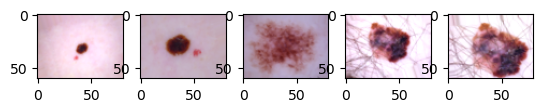

In [47]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.subplot(1,5,i+1) # 행 하나, 열 다섯 개, 1로 시작하는 인덱스
    # 이미지 데이터를 부동 소수점으로 변환하여 픽셀 값을 0에서 1 사이로 만듭니다.
    plt.imshow(augmented_mel.iloc[i*3]['image'].astype('float32') / 255)
plt.show()

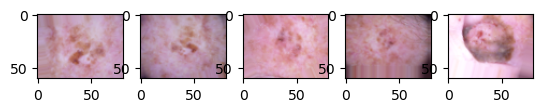

In [48]:
for i in range(5):
    plt.subplot(1,5,i+1) # 행 하나, 열 다섯 개, 1로 시작하는 인덱스
    # 이미지 데이터를 부동 소수점으로 변환하여 픽셀 값을 0에서 1 사이로 만듭니다.
    plt.imshow(augmented_bkl.iloc[i*3]['image'].astype('float32') / 255)
plt.show()

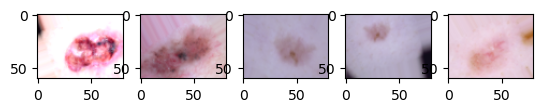

In [38]:
for i in range(5):
    plt.subplot(1,5,i+1) # 행 하나, 열 다섯 개, 1로 시작하는 인덱스
    # 이미지 데이터를 부동 소수점으로 변환하여 픽셀 값을 0에서 1 사이로 만듭니다.
    plt.imshow(augmented_bcc.iloc[i*6]['image'].astype('float32') / 255)
plt.show()


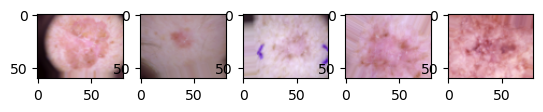

In [46]:
for i in range(5):
    plt.subplot(1,5,i+1) # 행 하나, 열 다섯 개, 1로 시작하는 인덱스
    # 이미지 데이터를 부동 소수점으로 변환하여 픽셀 값을 0에서 1 사이로 만듭니다.
    plt.imshow(augmented_akiec.iloc[i*8]['image'].astype('float32') / 255)
plt.show()


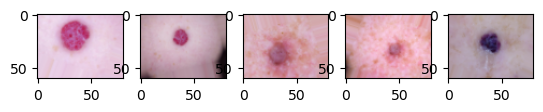

In [45]:
for i in range(5):
    plt.subplot(1,5,i+1) # 행 하나, 열 다섯 개, 1로 시작하는 인덱스
    # 이미지 데이터를 부동 소수점으로 변환하여 픽셀 값을 0에서 1 사이로 만듭니다.
    plt.imshow(augmented_vasc.iloc[i*14]['image'].astype('float32') / 255)
plt.show()


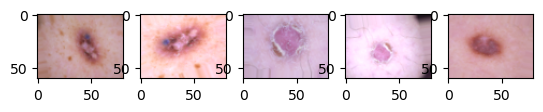

In [44]:
for i in range(5):
    plt.subplot(1,5,i+1) # 행 하나, 열 다섯 개, 1로 시작하는 인덱스
    # 이미지 데이터를 부동 소수점으로 변환하여 픽셀 값을 0에서 1 사이로 만듭니다.
    plt.imshow(augmented_df.iloc[i*20]['image'].astype('float32') / 255)
plt.show()


In [49]:
# Checking the image size distribution
merged_df['image'].map(lambda x: x.shape).value_counts()

image
(60, 80, 3)    26639
Name: count, dtype: int64

In [54]:
merged_df.shape[0]

26639

In [55]:
# 이미지 정규화
for i in range(merged_df.shape[0]):
    merged_df.at[i, 'image'] = merged_df.at[i, 'image'].astype('float32') / 255 


In [56]:
inputs = merged_df[['age', 'sex', 'localization', 'image']]
labels=merged_df['cell_type_idx']
inputs.head()

,age,sex,localization,image
0,80.0,male,scalp,"[[[0.7490196, 0.5921569, 0.75686276], [0.74901..."
1,80.0,male,scalp,"[[[0.09019608, 0.050980393, 0.08627451], [0.09..."
2,80.0,male,scalp,"[[[0.7254902, 0.5019608, 0.54509807], [0.74509..."
3,80.0,male,scalp,"[[[0.09019608, 0.043137256, 0.07058824], [0.12..."
4,75.0,male,ear,"[[[0.5372549, 0.3647059, 0.45490196], [0.6, 0...."


In [57]:
labels.head()

0    2
1    2
2    2
3    2
4    2
Name: cell_type_idx, dtype: object

In [59]:
x_train, x_test, y_train, y_test = train_test_split(inputs, labels, test_size=0.2,random_state=1234)

In [60]:
inputs['image'][0].shape

(60, 80, 3)

In [61]:
y_train = to_categorical(y_train, num_classes = 7)
y_test = to_categorical(y_test, num_classes = 7)

In [62]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [66]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
#x_train = x_train.reshape(x_train.shape[0], *(60, 80, 3))
#x_test = x_test.reshape(x_test.shape[0], *(60, 80, 3))
#x_validate = x_validate.reshape(x_validate.shape[0], *(60, 80, 3))
x_train.iloc[15180]['image'].shape


(60, 80, 3)

In [132]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, concatenate, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model

# 이미지 입력 레이어
image_input = Input(shape=(60, 80, 3), name='image_input')
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(image_input)
conv1 = BatchNormalization()(conv1)
conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)  # 추가된 합성곱 층
conv2 = BatchNormalization()(conv2)
pool1 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)  # 추가된 합성곱 층
conv3 = BatchNormalization()(conv3)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)  # 추가된 합성곱 층
conv4 = BatchNormalization()(conv4)
pool3 = MaxPooling2D((2, 2))(conv4)
flatten1 = Flatten()(pool3)

# 나이 입력 레이어
age_input = Input(shape=(1,), name='age_input')

# 성별 입력 레이어
sex_input = Input(shape=(3,), name='sex_input')

# 발병위치 입력 레이어
localization_input = Input(shape=(15,), name='localization_input')

# 모든 입력을 결합하는 레이어
combined_input = concatenate([flatten1, age_input, sex_input, localization_input])

# Fully Connected Layer
dense1 = Dense(128, activation='relu')(combined_input)
dropout1 = Dropout(0.5)(dense1)
dense2 = Dense(64, activation='relu')(dropout1)
dropout2 = Dropout(0.5)(dense2)

# 출력 레이어 (다중 클래스 분류)
output = Dense(7, activation='softmax')(dropout2)  # 7가지 질병 클래스 중 하나 예측

# 모델 생성
model = Model(inputs=[image_input, age_input, sex_input, localization_input], outputs=output)

from keras.optimizers import Adam
Adam_custom = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999) # epsilon=None, amsgrad=False

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 요약 출력
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)      │ (None, 60, 80, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, 60, 80, 32)        │             896 │ image_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_8         │ (None, 60, 80, 32)        │             128 │ conv2d_8[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_9 (Conv2D)             │ (None, 60, 80, 32)        │           9,248 │ batch_normalization_8[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_9         │ (None, 60, 80, 32)        │             128 │ conv2d_9[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_4               │ (None, 30, 40, 32)        │               0 │ batch_normalization_9[0][… │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_10 (Conv2D)            │ (None, 30, 40, 64)        │          18,496 │ max_pooling2d_4[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_10        │ (None, 30, 40, 64)        │             256 │ conv2d_10[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_11 (Conv2D)            │ (None, 30, 40, 64)        │          36,928 │ batch_normalization_10[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_11        │ (None, 30, 40, 64)        │             256 │ conv2d_11[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_5               │ (None, 15, 20, 64)        │               0 │ batch_normalization_11[0]… │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_2 (Flatten)           │ (None, 19200)             │               0 │ max_pooling2d_5[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ age_input (InputLayer)        │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sex_input (InputLayer)        │ (None, 3)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 2,535,207 (9.67 MB)

 Trainable params: 2,534,823 (9.67 MB)

 Non-trainable params: 384 (1.50 KB)

In [133]:
from tensorflow.keras.utils import to_categorical

# 이미지 데이터의 경우 0~2351 열까지는 이미지 데이터
X_train_image = x_train['image']

# 나이 데이터는 2352번째 열
X_train_age = x_train['age']

# 성별 데이터는 2353~2355번째 열 (One-Hot Encoding된 형태로 입력)
X_train_sex = x_train['sex']

# 발병위치 데이터는 2356~2369번째 열 (One-Hot Encoding된 형태로 입력)
X_train_localization = x_train['localization']

# y_train은 위에서 원-핫 인코딩 이미 해줌

In [134]:
print(type(X_train_image))
print(type(X_train_age))
print(type(X_train_sex))
print(type(X_train_localization))
print(type(y_train))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [146]:
print(type(X_train_image))
X_train_image

<class 'pandas.core.series.Series'>


15180    [[[0.7921569, 0.6862745, 0.70980394], [0.8, 0....
9269     [[[0.63529414, 0.40784314, 0.3764706], [0.6509...
7014     [[[0.5764706, 0.50980395, 0.61960787], [0.5764...
10661    [[[0.78431374, 0.6627451, 0.7137255], [0.78431...
11396    [[[0.20392157, 0.15294118, 0.16862746], [0.192...
                               ...                        
26505    [[[0.78039217, 0.49803922, 0.62352943], [0.780...
16887    [[[0.6117647, 0.54901963, 0.5686275], [0.60784...
11534    [[[0.6862745, 0.6509804, 0.69411767], [0.68627...
15527    [[[0.57254905, 0.40392157, 0.38431373], [0.588...
5039     [[[0.92156863, 0.6117647, 0.6666667], [0.92549...
Name: image, Length: 19179, dtype: object

In [159]:
print(type(X_train_age))
X_train_age

<class 'pandas.core.series.Series'>


15180    35.0
9269     60.0
7014     45.0
10661    75.0
11396    55.0
         ... 
26505    35.0
16887    50.0
11534    70.0
15527    55.0
5039     65.0
Name: age, Length: 19179, dtype: object

In [160]:
print(type(X_train_sex))
X_train_sex

<class 'pandas.core.series.Series'>


15180    female
9269     female
7014       male
10661    female
11396    female
          ...  
26505    female
16887    female
11534      male
15527      male
5039       male
Name: sex, Length: 19179, dtype: object

In [138]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# 먼저 레이블 인코딩(Label Encoding)을 수행하여 카테고리를 숫자로 변환합니다.
label_encoder_sex = LabelEncoder()
localized_labels_sex = label_encoder_sex.fit_transform(X_train_sex)

# 다음으로 원-핫 인코딩(One-hot Encoding)을 수행합니다.
onehot_encoder_sex = OneHotEncoder()
X_train_sex_one_hot = onehot_encoder_sex.fit_transform(localized_labels_sex.reshape(-1, 1))

print(X_train_sex_one_hot.shape)

(19179, 3)


In [153]:
print(type(X_train_sex_one_hot))

<class 'scipy.sparse._csr.csr_matrix'>


In [140]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# 먼저 레이블 인코딩(Label Encoding)을 수행하여 카테고리를 숫자로 변환합니다.
label_encoder = LabelEncoder()
localized_labels = label_encoder.fit_transform(X_train_localization)

# 다음으로 원-핫 인코딩(One-hot Encoding)을 수행합니다.
onehot_encoder = OneHotEncoder()
X_train_localized_onehot = onehot_encoder.fit_transform(localized_labels.reshape(-1, 1))

print(X_train_localized_onehot.shape)

(19179, 15)


In [154]:
print(y_train.shape)
print(type(y_train))

(19179, 7)
<class 'tensorflow.python.framework.ops.EagerTensor'>


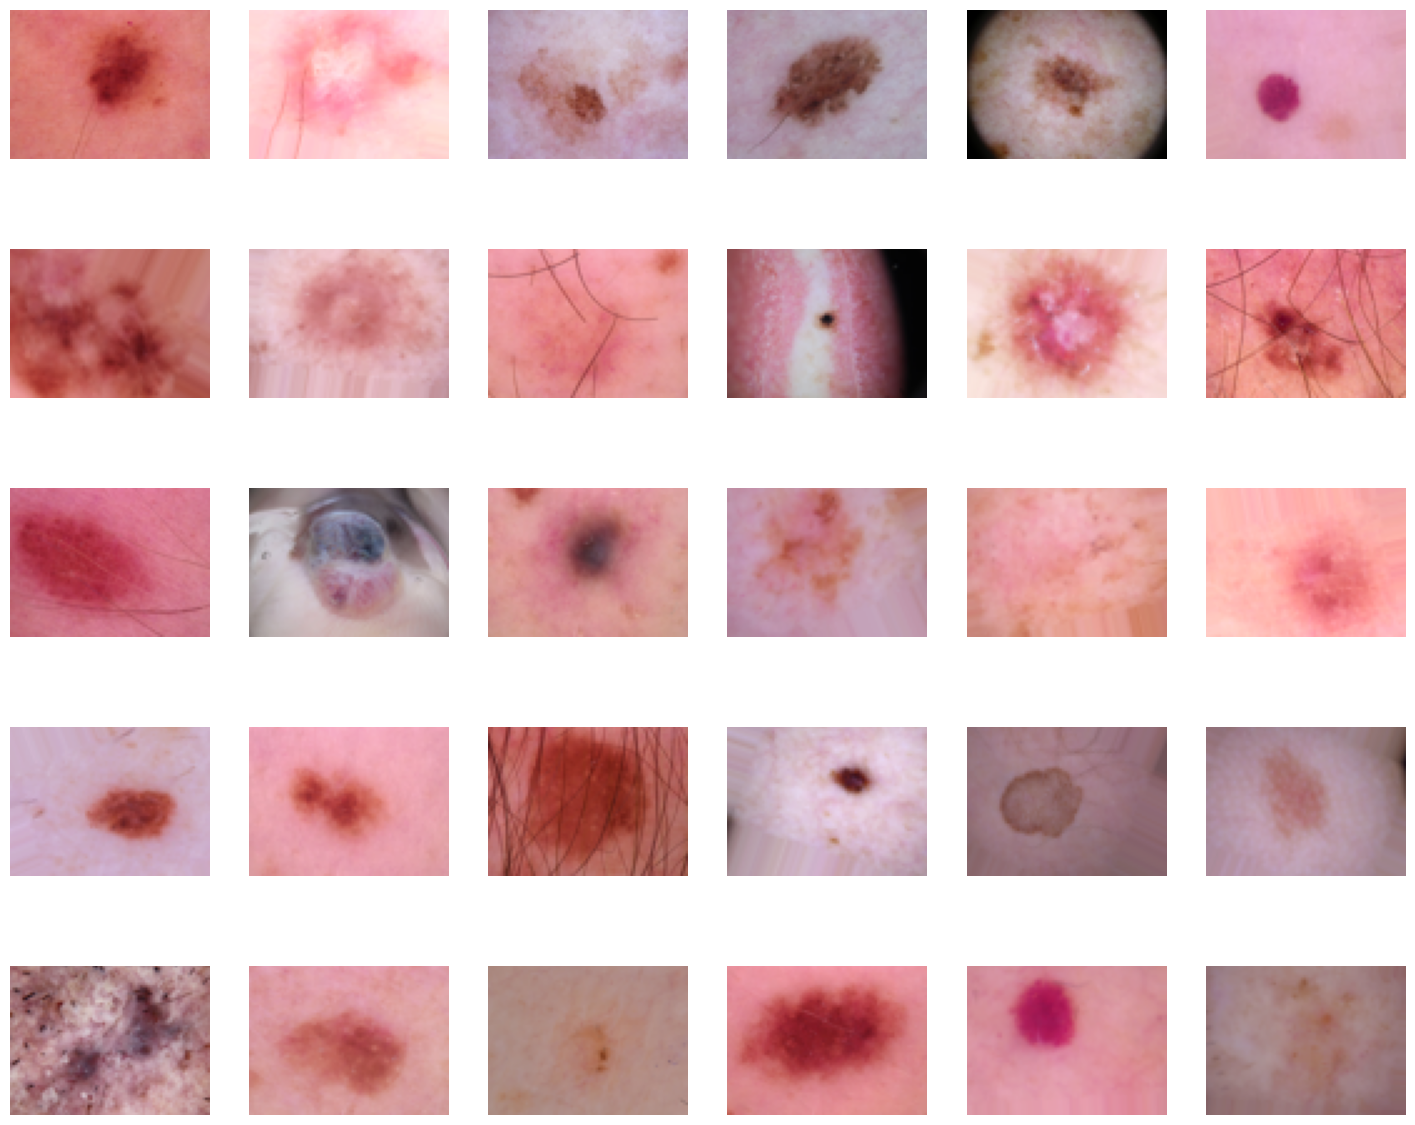

In [142]:
import matplotlib.pyplot as plt
import random

# 이미지 데이터 중에서 랜덤으로 30개 선택
random_images = random.sample(merged_df['image'].tolist(), 30)

# 선택된 이미지 시각화
fig, axes = plt.subplots(5, 6, figsize=(18, 15))

for i, image in enumerate(random_images):
    ax = axes[i // 6, i % 6]  # subplot 인덱스 계산
    ax.imshow(image)
    ax.axis('off')

plt.show()


In [158]:
import numpy as np

# 이미지 데이터를 넘파이 배열로 변환
X_train_image_np = np.array([np.array(image) for image in X_train_image])

# 이미지 데이터의 형태 확인
print("이미지 데이터의 형태:", X_train_image_np.shape)
print("이미지 데이터의 타입:", type(X_train_image_np))


이미지 데이터의 형태: (19179, 60, 80, 3)
이미지 데이터의 타입: <class 'numpy.ndarray'>


In [166]:
X_train_age_np = np.array([np.array(age) for age in X_train_age])


print("이미지 데이터의 형태:", X_train_age_np.shape)
print("이미지 데이터의 타입:", type(X_train_age_np))

이미지 데이터의 형태: (19179,)
이미지 데이터의 타입: <class 'numpy.ndarray'>


In [167]:
X_train_sex_one_hot_np = X_train_sex_one_hot.toarray()

print("이미지 데이터의 형태:", X_train_sex_one_hot_np.shape)
print("이미지 데이터의 타입:", type(X_train_sex_one_hot_np))


이미지 데이터의 형태: (19179, 3)
이미지 데이터의 타입: <class 'numpy.ndarray'>


In [168]:
X_train_localization_one_hot_np = X_train_localization_one_hot.toarray()

print("이미지 데이터의 형태:", X_train_localization_one_hot_np.shape)
print("이미지 데이터의 타입:", type(X_train_localization_one_hot_np))


이미지 데이터의 형태: (19179, 15)
이미지 데이터의 타입: <class 'numpy.ndarray'>


In [169]:
print("이미지 데이터의 형태:", y_train.shape)
print("이미지 데이터의 타입:", type(y_train))

이미지 데이터의 형태: (19179, 7)
이미지 데이터의 타입: <class 'tensorflow.python.framework.ops.EagerTensor'>


In [ ]:
print("이미지 데이터의 타입:", type(X_train_image_np))
print("이미지 데이터의 타입:", type(X_train_age_np))
print("이미지 데이터의 타입:", type(X_train_sex_one_hot_np))
print("이미지 데이터의 타입:", type(X_train_localization_one_hot_np))
print("이미지 데이터의 타입:", type(y_train))


# 모델을 훈련시킴
history = model.fit([X_train_image_np, X_train_age_np, X_train_sex_one_hot_np, X_train_localization_one_hot_np], y_train,
                    epochs=50,
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[reduce_lr])


이미지 데이터의 타입: <class 'numpy.ndarray'>
이미지 데이터의 타입: <class 'numpy.ndarray'>
이미지 데이터의 타입: <class 'numpy.ndarray'>
이미지 데이터의 타입: <class 'numpy.ndarray'>
이미지 데이터의 타입: <class 'tensorflow.python.framework.ops.EagerTensor'>
Epoch 1/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 133s 500ms/step - accuracy: 0.2157 - loss: 2.6875 - val_accuracy: 0.1470 - val_loss: 6.4280 - learning_rate: 0.0010
Epoch 2/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 115s 478ms/step - accuracy: 0.2493 - loss: 1.8929 - val_accuracy: 0.2563 - val_loss: 1.8774 - learning_rate: 0.0010
Epoch 3/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 122s 507ms/step - accuracy: 0.2509 - loss: 1.8828 - val_accuracy: 0.2568 - val_loss: 1.8728 - learning_rate: 0.0010
Epoch 4/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 114s 475ms/step - accuracy: 0.2528 - loss: 1.8813 - val_accuracy: 0.2568 - val_loss: 1.8715 - learning_rate: 0.0010
Epoch 5/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 122s 506ms/step - accuracy: 0.2477 - loss: 1.8794 - val_accuracy: 0.2568 - val_loss: 1.8712 - learning_rate: 0.0010
Epoch